# De novo design

### Developers: Mat Bieniek, Ben Cree, Rachael Pirie, Josh Horton

* Add R-groups in user-defined positions
* Output ADMET properties
* Perform constrained optimisation
* Score poses
* Send output to free energy calculations

Open source, customisable, fast/easy to use.

In [1]:
import copy
import glob
import prody
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
from rgroup import RMol, RList, build_molecules, fix_receptor, optimise_in_receptor, RGroups, sort_conformers, ic50

<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [2]:
%pwd

'/home/c0065492/rgroups/temp/rgroups_git/data/bace_dat'

In [3]:
prefix = 'lig_CAT-' #to extract experimental data from ligands.yml

In [4]:
!wget -nc https://files.rcsb.org/download/4DJW.pdb
pdb = '4DJW.pdb'

File ‘4DJW.pdb’ already there; not retrieving.



In [5]:
RMol.set_gnina(loc='/home/c0065492/software/gnina')

In [6]:
# load the complex with the ligand
sys = prody.parsePDB(pdb)
#sys = prody.parsePDB('jnk1/2gmx.pdb')

rec = sys.select('not (nucleic or hetatm) and not water')
#mol = sys.select('resname 19H and chain A')
mol = sys.select('resname 0X5')

prody.writePDB('rec.pdb', rec)
#prody.writePDB('lig.pdb', mol)

@> 7079 atoms and 1 coordinate set(s) were parsed in 0.07s.


'rec.pdb'

In [7]:
#!wget 'https://models.rcsb.org/v1/5nev/ligand?auth_seq_id=301&label_asym_id=E&encoding=sdf&filename=5nev_E_72L.sdf' -O lig.sdf
#!obabel jnk1/core.sdf -O jnk1/coreh.sdf -p 7
!obabel -isdf core.sdf -osdf -O coreh.sdf -p 7
# ^manually modify the files if need be
%pwd

1 molecule converted


'/home/c0065492/rgroups/temp/rgroups_git/data/bace_dat'

In [8]:
# load the ligand
# rdkit doesn't do a good job with protonation, 
#init_mol = Chem.MolFromPDBFile('lig.pdb', removeHs=False)
#init_mol = Chem.AddHs(init_mol, addCoords=True)

init_mol = Chem.SDMolSupplier('coreh.sdf', removeHs=False)[0]

# get the R group representation of the rdkit Mol
rinit_mol = RMol(init_mol)

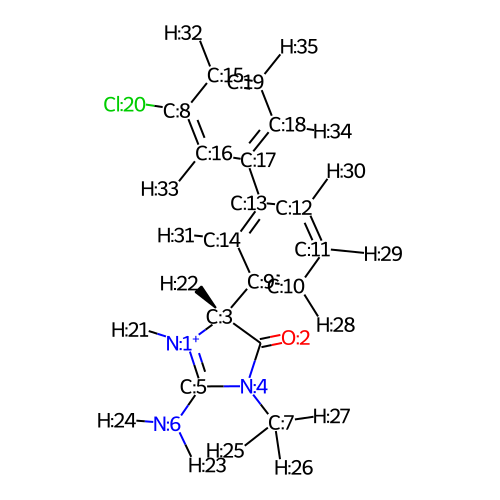

In [9]:
# select the atom to be replaced with the R group
rinit_mol.rep2D(idx=True, size=(500, 500))

In [10]:
#remove 44 since all conformers clash with protein
ligand_ids = ['13a', '13b', '13c', '13d', '13e', '13f', '13g', '13h', '13i', '13j', '13k', '13m', '13n', '13o']
# read the rgroups 1 by 1 in a loop
# assumes that there is only one -r.mol in each dir
rgroups = [Chem.MolFromMolFile(glob.glob(f'{ligand_id}/*.mol')[0], removeHs=False) for ligand_id in ligand_ids]
rgroups

In [11]:
len(ligand_ids) #to check what rgroup is failing optimisation or clash with protein)

14

In [12]:
# build a list of molecules
attachment_index = [22]
rmols = build_molecules(rinit_mol, attachment_index, rgroups)

Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f83b7e386a0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f83b7e38700>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f83b7e38d00> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f83b7e38dc0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f83b7e38700> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f83b7e386a0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f83b7e38d00> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f83b7e38dc0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f83b7e386a0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f83b7e38700>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f83b7e38d00> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f83b7e38dc0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f83b7e38700> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f83b7e386a0>
Rgroup atom index <rdkit.Chem.rdchem.QueryAtom o

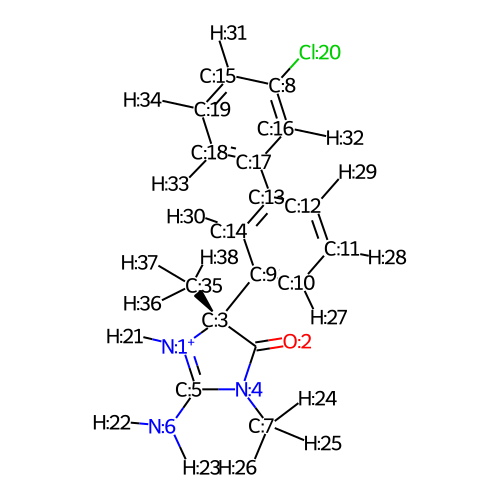

In [13]:
rmols[0].rep2D(idx=True, size=(500, 500))

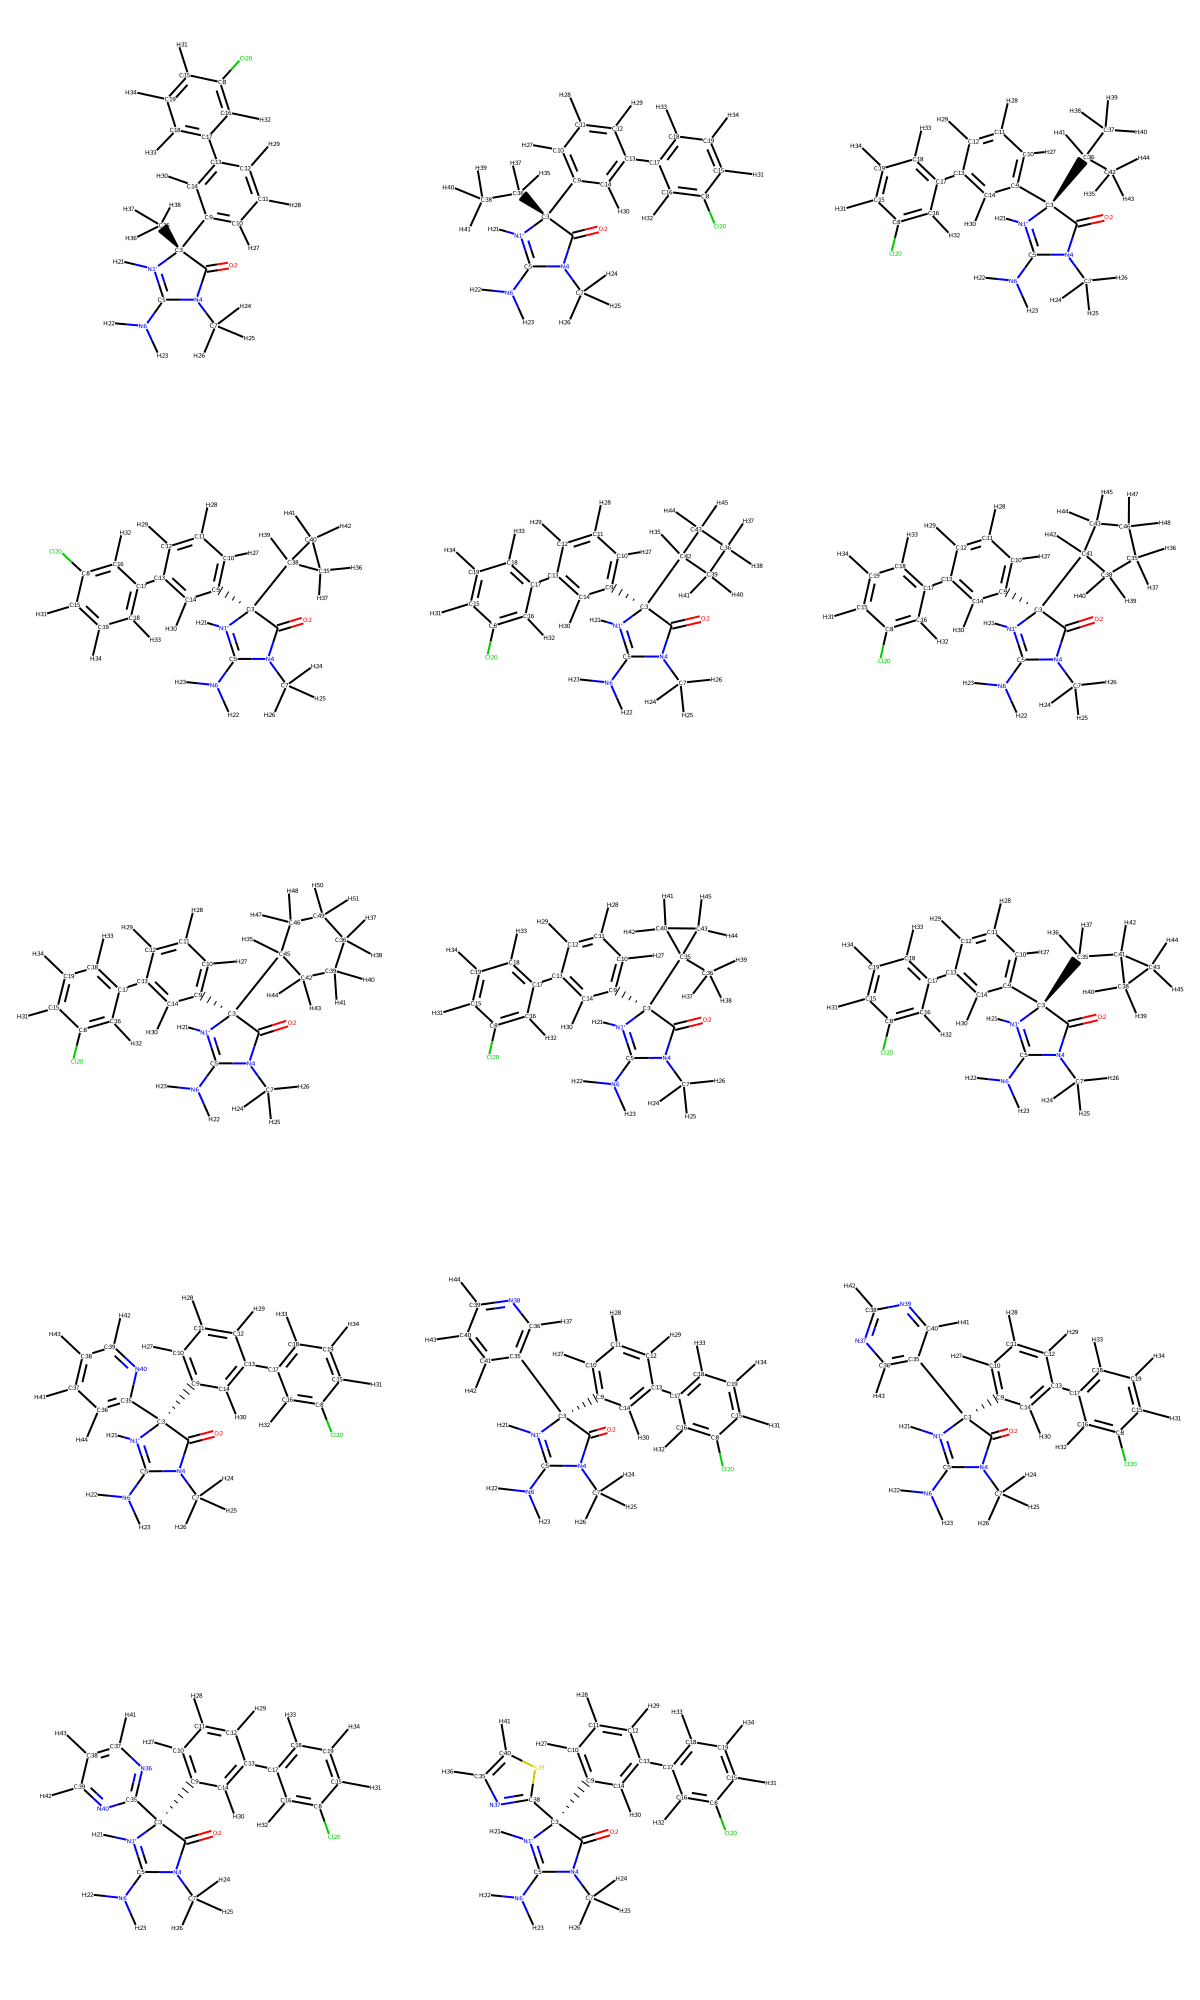

In [14]:
rmols.rep2D()

In [15]:
rmols[3].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [16]:
rmols.toxicity()

MW  HBA  HBD    LogP  Pass_Ro5  has_pains  has_unwanted_subs  \
0  314.105466    2    2  1.0895      True      False              False   
0  328.121116    2    2  1.4796      True      False              False   
0  342.136766    2    2  1.7256      True      False              False   
0  340.121116    2    2  1.4796      True      False              False   
0  354.136766    2    2  1.8697      True      False              False   
0  368.152416    2    2  2.2598      True      False              False   
0  382.168067    2    2  2.6499      True      False              False   
0  354.136766    2    2  1.8697      True      False              False   
0  354.136766    2    2  1.8697      True      False              False   
0  377.116365    3    2  1.5129      True      False              False   
0  377.116365    3    2  1.5129      True      False              False   
0  378.111614    4    2  0.9079      True      False              False   
0  378.111614    4    2  0.9079      True      False              False   
0  383.072786    4    2  1.5744      True      False              False   

   has_prob_fgs  synthetic_accessibility  
0         False                 6.526662  
0         False                 7.115256  
0         False                 7.467926  
0         False                 7.138845  
0         False                 7.525201  
0         False                 7.744706  
0         False                 7.888814  
0         False                 7.461444  
0         False                 7.485596  
0         False                 6.793978  
0         False                 6.762293  
0         False                 6.070135  
0         False                 6.135503  
0         False                 5.155128

In [17]:
rmols.generate_conformers(num_conf=200,
                         minimum_conf_rms=0.5,
                         #flexible = [16, 17, 18, 27]
                         )

RMol index 0
removed 198 duplicated conformations
RMol index 1
removed 193 duplicated conformations
RMol index 2
removed 169 duplicated conformations
RMol index 3
removed 188 duplicated conformations
RMol index 4
removed 176 duplicated conformations
RMol index 5
removed 142 duplicated conformations
RMol index 6
removed 122 duplicated conformations
RMol index 7
removed 175 duplicated conformations
RMol index 8
removed 170 duplicated conformations
RMol index 9
removed 198 duplicated conformations
RMol index 10
removed 198 duplicated conformations
RMol index 11
removed 198 duplicated conformations
RMol index 12
removed 198 duplicated conformations
RMol index 13
removed 198 duplicated conformations


In [18]:
#rmol.rep3D(template=True)

In [19]:
rmols.GetNumConformers()

[3, 8, 32, 13, 25, 59, 79, 26, 31, 3, 3, 3, 3, 3]

### Optimise conformers in context of protein

In [20]:
# fix the receptor file 
fix_receptor("rec.pdb", "rec_h.pdb")
# load back into prody
rec_fix = prody.parsePDB("rec_h.pdb")

@> 12049 atoms and 1 coordinate set(s) were parsed in 0.07s.


In [21]:
# filter by the protein clashes
rmols[2].rep3D(prody=rec_fix)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [22]:
rmols.removeConfsClashingWithProdyProt(rec_fix)

RMol index 0
RMol index 1
RMol index 2
RMol index 3
RMol index 4
RMol index 5
RMol index 6
Clash with the protein. Removing conformer id: 51
Clash with the protein. Removing conformer id: 39
Clash with the protein. Removing conformer id: 20
Clash with the protein. Removing conformer id: 16
RMol index 7
RMol index 8
Clash with the protein. Removing conformer id: 30
Clash with the protein. Removing conformer id: 28
Clash with the protein. Removing conformer id: 25
Clash with the protein. Removing conformer id: 20
Clash with the protein. Removing conformer id: 19
Clash with the protein. Removing conformer id: 17
RMol index 9
RMol index 10
RMol index 11
RMol index 12
RMol index 13


In [23]:
rmols.GetNumConformers()

[3, 8, 32, 13, 25, 59, 75, 26, 25, 3, 3, 3, 3, 3]

In [24]:
len(ligand_ids)

14

In [25]:
rmols[2].rep3D(prody=rec_fix)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [26]:
# opt_mol, energies
energies = rmols.optimise_in_receptor(
    receptor_file="rec_h.pdb", 
    ligand_force_field="openff", 
    use_ani=True,
    sigma_scale_factor=0.8,
    relative_permittivity=4
)

RMol index 0


Optimising conformer: 100%|███████████████████████| 3/3 [00:24<00:00,  8.02s/it]


RMol index 1


Optimising conformer: 100%|███████████████████████| 8/8 [00:56<00:00,  7.10s/it]


RMol index 2


Optimising conformer: 100%|█████████████████████| 32/32 [04:22<00:00,  8.20s/it]


RMol index 3


Optimising conformer: 100%|█████████████████████| 13/13 [01:44<00:00,  8.04s/it]


RMol index 4


Optimising conformer: 100%|█████████████████████| 25/25 [04:18<00:00, 10.36s/it]


RMol index 5


Optimising conformer: 100%|█████████████████████| 59/59 [08:26<00:00,  8.59s/it]


RMol index 6


Optimising conformer: 100%|█████████████████████| 75/75 [13:29<00:00, 10.79s/it]


RMol index 7


Optimising conformer: 100%|█████████████████████| 26/26 [03:58<00:00,  9.19s/it]


RMol index 8


Optimising conformer: 100%|█████████████████████| 25/25 [03:53<00:00,  9.35s/it]


RMol index 9


Optimising conformer: 100%|███████████████████████| 3/3 [00:27<00:00,  9.07s/it]


RMol index 10


Optimising conformer: 100%|███████████████████████| 3/3 [00:25<00:00,  8.66s/it]


RMol index 11


Optimising conformer: 100%|███████████████████████| 3/3 [00:26<00:00,  8.77s/it]


RMol index 12


Optimising conformer: 100%|███████████████████████| 3/3 [00:32<00:00, 10.70s/it]


RMol index 13


Optimising conformer: 100%|███████████████████████| 3/3 [00:31<00:00, 10.57s/it]


In [27]:
rmols[0].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [28]:
for i in range(len(ligand_ids)):
    rmols[i].to_file("optimised_coords_" + str(ligand_ids[i]) + ".pdb")

In [29]:
final_energies = rmols.sort_conformers(energy_range=5)

RMol index 0
RMol index 1
RMol index 2
RMol index 3
RMol index 4
RMol index 5
RMol index 6
RMol index 7
RMol index 8
RMol index 9
RMol index 10
RMol index 11
RMol index 12
RMol index 13


In [30]:
for i in range(len(ligand_ids)):
    rmols[i].to_file("best_conformers_" + str(ligand_ids[i]) + ".pdb")

In [31]:
CNNscores = rmols.gnina(receptor_file="rec_h.pdb") 

RMol index 0
RMol index 1
RMol index 2
RMol index 3
RMol index 4
RMol index 5
RMol index 6
RMol index 7
RMol index 8
RMol index 9
RMol index 10
RMol index 11
RMol index 12
RMol index 13


In [32]:
ic50_scores = []
for i in range(len(CNNscores)):
    ic50_scores.append([ic50(x) for x in CNNscores[i]])

In [33]:
for i in range(len(ic50_scores)):
    with open('scores_' + str(ligand_ids[i]) + '.dat', 'w') as f:
        for x in range(len(ic50_scores[i])):
            f.write(str(ic50_scores[i][x])+'\n')

In [34]:
lowest = []
for i in range(len(ic50_scores)):
    try:
        lowest.append(ic50_scores[i][0])
    except:
        pass

In [35]:
import yaml
with open("ligands.yml", "r") as stream:
    try:
        data = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

experimental = []
for i in range(len(ligand_ids)):
    experimental.append(data[prefix+ str(ligand_ids[i])]['measurement']['value'])
experimental #for some reason no ic50 values only kJ/mol

[720, 450, 320, 47, 110, 470, 470, 190, 350, 860, 170, 830, 1200, 1200]

In [36]:
len(experimental)

14

In [37]:
import pandas as pd
#rmol that has no conformers causes issues, potential fix is look for None in final_energies/CNNscore and delete that element from all of the following so theyre the same size & can be plotted?
name = [ligand_ids[i:i+1] for i in range(0, len(ligand_ids), 1)]
energies = [i[0] for i in final_energies]
cnn = [i[0] for i in CNNscores]
ic50 = [i[0] for i in ic50_scores]
expt = [i for i in experimental]
output = pd.DataFrame({'ID' : name, 'Final energies' : energies, 'Gnina score' : cnn, 'Gnina IC50 / nM' : ic50, 'Experimental IC50 / nM' : expt})
output

ID  Final energies  Gnina score  Gnina IC50 / nM  \
0   [13a]             0.0      6.33716       460.087040   
1   [13b]             0.0      6.57704       264.825621   
2   [13c]             0.0      6.85824       138.598969   
3   [13d]             0.0      6.88733       129.619398   
4   [13e]             0.0      7.09705        79.974218   
5   [13f]             0.0      7.23076        58.781410   
6   [13g]             0.0      7.30571        49.464087   
7   [13h]             0.0      7.03835        91.548240   
8   [13i]             0.0      7.02321        94.795997   
9   [13j]             0.0      6.98283       104.032731   
10  [13k]             0.0      7.14794        71.131178   
11  [13m]             0.0      6.97713       105.407133   
12  [13n]             0.0      6.76988       169.871296   
13  [13o]             0.0      6.84238       143.754021   

    Experimental IC50 / nM  
0                      720  
1                      450  
2                      320  
3                       47  
4                      110  
5                      470  
6                      470  
7                      190  
8                      350  
9                      860  
10                     170  
11                     830  
12                    1200  
13                    1200

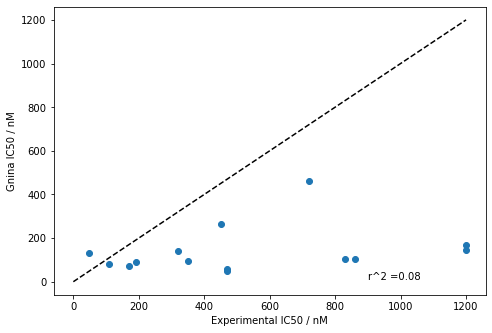

'0.08'

In [38]:
import matplotlib.pyplot as plt
import numpy as np

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(experimental, lowest) #, color='black', marker='x')
ax.set_xlabel('Experimental IC50 / nM')
ax.set_ylabel('Gnina IC50 / nM')

x = np.linspace(0,1200,25)
y = np.linspace(0,1200,25)
ax.plot(x, y, color='black', linestyle='--')

m, cf = np.polyfit(experimental,lowest,1)
m = "{:.2f}".format(m)
r = "r^2 =" + str(m)
#poly1d_fn = np.poly1d(coef) 
plt.savefig('out.png', bbox_inches='tight')
plt.annotate(r, (900,10))
plt.show()
m

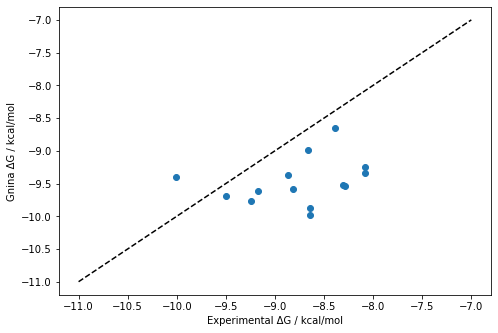

In [39]:
# convert nM to M
lowestinM = [ i * 1e-9 for i in lowest]
exptinM = [ i * 1e-9 for i in experimental]

RT = 0.593 # kcal/mol

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

# DG = RTln(K)
ax.scatter(RT*np.log(exptinM), RT*np.log(lowestinM)) #, color='black', marker='x')
ax.set_xlabel('Experimental \u0394G / kcal/mol')
ax.set_ylabel('Gnina \u0394G / kcal/mol')

x = np.linspace(-11,-7,10)
ax.plot(x, x, color='black', linestyle='--')
A = np.vstack([experimental, np.ones(len(experimental))]).T
m, c = np.linalg.lstsq(A, lowest, rcond=None)[0]

m = "{:.2f}".format(m)
r = "r^2 =" + str(m)
plt.annotate(r, (-10,-6))
plt.savefig('deltaG2.png', bbox_inches='tight')
plt.show()

In [40]:
import re
smina_affinities = []
with open('smina_scores.dat', 'r') as f:
    for line in f:
        affinity = re.findall(r'Affinity: -?(-\d+.\d+)', str(line))
        try:
            smina_affinities.append(float(affinity[0]))
        except:
            pass

In [41]:
len(smina_affinities)

15

ValueError: x and y must be the same size

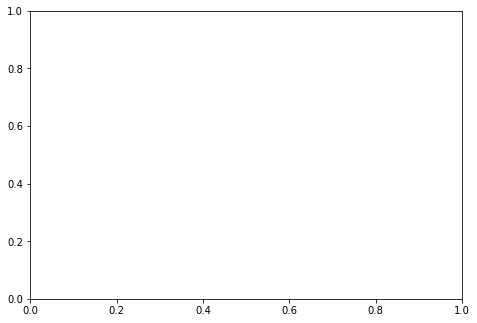

In [42]:
# convert nM to M
lowestinM = [ i * 1e-9 for i in lowest]
exptinM = [ i * 1e-9 for i in expt]

RT = 0.593 # kcal/mol

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

# DG = RTln(K)
ax.scatter(RT*np.log(exptinM), smina_affinities) #, color='black', marker='x')
ax.set_xlabel('Experimental \u0394G / kcal/mol')
ax.set_ylabel('Gnina \u0394G / kcal/mol')

x = np.linspace(-11,-7,10)
ax.plot(x, x, color='black', linestyle='--')
A = np.vstack([experimental, np.ones(len(experimental))]).T
m, c = np.linalg.lstsq(A, lowest, rcond=None)[0]

m = "{:.2f}".format(m)
r = "r^2 =" + str(m)
plt.annotate(r, (-10,-6))
plt.savefig('deltaG2_smina.png', bbox_inches='tight')
plt.show()

In [ ]:
import dill
dill.load_session('notebook_bace_19jan.db')

In [ ]:
CNNscores